# Vector Quatized Variational Autoencoders

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import tqdm
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

    Control Device:

In [2]:
devices=("cuda" if torch.cuda.is_available() else "cpu")

    Constants:

In [3]:
Epochs=25
Learning_rate=2e-4
Num_Embeddings=128
Channel_size=3
save_path="VQ-VAE_model.pth.tar"
Load_Model=True

    Create Transforms, Dataset and Dataloader:

In [4]:
# Transformer
transformer=transforms.Compose([transforms.ToTensor(),
                    transforms.Normalize((0.5,),(0.5,))])

# Train Dataset
train_dataset=datasets.CIFAR10("Cifar10",train=True,transform=transformer,download=True)

# Train Dataloader
train_dataloader=DataLoader(dataset=train_dataset,batch_size=64,shuffle=True)


Files already downloaded and verified


    VQ-VAE Module:

In [5]:
class VQ_VAE(nn.Module):
    def __init__(self,channel_size,num_embeddings):
        super().__init__()
    
        self.initial_layer,self.res_block1,self.res_block2=self.Encoder(channel_size=channel_size)
        self.res_block1_d,self.res_block2_d,self.out_layer=self.Decoder(channel_size=channel_size)
        self.embedding=nn.Embedding(num_embeddings=num_embeddings,embedding_dim=256)
    
    # Encoder Blocks:
    def Encoder(self,channel_size):
        initial_layer=nn.Sequential(nn.Conv2d(in_channels=channel_size,out_channels=256,kernel_size=4,padding=1,stride=2,padding_mode="reflect"),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=256,out_channels=256,stride=2,kernel_size=4,padding=1,padding_mode="reflect"),
                                    nn.ReLU())
        res_block1=nn.Sequential(nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,padding_mode="reflect"),
                                 nn.ReLU())
        res_block2=nn.Sequential(nn.Conv2d(in_channels=256,out_channels=256,kernel_size=1))
        return initial_layer,res_block1,res_block2
    
    # Decoder Blocks:
    def Decoder(self,channel_size):

        res_block1=nn.Sequential(nn.ConvTranspose2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
                                 nn.ReLU())
        res_block2=nn.Sequential(nn.ConvTranspose2d(in_channels=256,out_channels=256,kernel_size=1))
        
        out_layer=nn.Sequential(nn.ConvTranspose2d(in_channels=256,out_channels=256,kernel_size=4,stride=2,padding=1),
                                nn.ReLU(),
                                nn.ConvTranspose2d(in_channels=256,out_channels=channel_size,stride=2,kernel_size=4,padding=1),
                                nn.ReLU())
        
        return res_block1,res_block2,out_layer
    
    # Latent Space ,calculate distances between embeddings and encoder output:
    def latent_space(self,pre_quatized,embedding):
        
        # Permute data because last dimesion should be channel
        data_perm=pre_quatized.permute(0,3,2,1)
        
        # Reshape (batch_size,last_img_size*last_img_size,channel)
        quanted_in=data_perm.reshape(data_perm.shape[0],-1,data_perm.shape[-1])
        
        # Claculate distance
        dist=torch.cdist(quanted_in,embedding.weight[None,:].repeat(quanted_in.shape[0],1,1))
        
        # Min distance index
        min_distance_indexes=torch.argmin(dist,dim=-1)
        
        # Change
        quanted_out=torch.index_select(embedding.weight,0,min_distance_indexes.view(-1))
        
        return quanted_in,quanted_out

    
    def forward(self,data):
        
        # Encoder Block
        x=self.initial_layer(data)
        x_r=self.res_block1(x)
        
        x_r=x_r+x   # Residual block
    
        pre_quatized=self.res_block2(x_r)
        
        pre_quatized=pre_quatized+x_r    # Residual block
        
        
        # Quatized vector with embeddings vector
        quanted_in,quanted_out=self.latent_space(pre_quatized=pre_quatized,embedding=self.embedding)
        quanted_in=quanted_in.reshape((-1,quanted_in.size(-1)))
        
        # Calculate Quantize Loss
        loss1=torch.mean((quanted_out.detach()-quanted_in)**2) 
        loss2=torch.mean((quanted_out-quanted_in.detach())**2)  
        loss_quantize=loss1+(0.25*loss2)                        
        
        quanted_out=quanted_in+(quanted_out-quanted_in).detach()
        
        # Reshape for decoder input (batch_size,channel,last_img_size,last_img_isze)
        B,C,H,W=pre_quatized.shape 
        quanted_out_reshaped=quanted_out.reshape(B,H,W,C).permute(0,3,1,2)  # reshape to be decoder input that its shape İS like the encoder output
        
        # Decoder 
        d_out1=self.res_block1_d(quanted_out_reshaped)        
        
        d_out2=self.res_block2_d(d_out1)
        
        d_out=d_out1+d_out2 # Residual
        
        out=self.out_layer(d_out)
        
        return out,loss_quantize    

        

    Create Model:

In [6]:
# Model
model=VQ_VAE(channel_size=Channel_size,num_embeddings=Num_Embeddings)
model.to(devices)

# Optimizer
optimizer=torch.optim.Adam(params=model.parameters(),lr=Learning_rate)

# Reconsturacter Loss
loss_fn=nn.MSELoss(reduction="sum")

    Model save:
    

In [7]:
def Save_model(model,optimizer,epoch,path):
    checkpoints={"Epochs":epoch,
                 "Optimizer_state":optimizer.state_dict,
                 "Model_states": model.state_dict}
    print("Model is saving...")
    torch.save(checkpoints,f=path)

    Load Model if Load_Model==True:

In [ ]:
if Load_Model==True:
    checkpoints=torch.load(save_path)
    model.load_state_dict(checkpoints["Model_states"])
    optimizer.load_state_dict(checkpoints["Optimizer_state"])
    initial_epoch=checkpoints["Epochs"]
    print(f"Training is starting {initial_epoch+1}.epoch")
else:
    initial_epoch=0
    print("Training is starting from scratch")

    Training:

In [8]:
def Training(epochs,train_dataloader,optimizer,model,loss_fn,Save_path,save_model_fn):

    for epoch in range(initial_epoch,epochs):
        
        prograss_bar=tqdm.tqdm(range(len(train_dataloader)),"Train proccess")
        
        for batch,(img,_label_) in enumerate(train_dataloader):
            
            img=img.to(devices)
            
            optimizer.zero_grad()
            out,loss_quantize=model(img)
            reconstruction_loss=loss_fn(out,img)
            loss = reconstruction_loss+loss_quantize
            
            loss.backward()
            optimizer.step()
            prograss_bar.update(1)   
        
        prograss_bar.set_postfix({"EPOCH":epoch+1,"step":batch+1,"LOSS": (loss.item()/(batch+1))})
        prograss_bar.close()
        save_model_fn(model,optimizer,epoch+1,Save_path)
    

In [9]:
Training(epochs=Epochs,train_dataloader=train_dataloader,optimizer=optimizer,model=model,loss_fn=loss_fn,Save_path=save_path,save_model_fn=Save_model)

Train proccess: 100%|██████████| 782/782 [04:48<00:00,  2.71it/s, EPOCH=1, step=782, LOSS=2.13e+3]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:38<00:00,  2.81it/s, EPOCH=2, step=782, LOSS=1.78e+3]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:55<00:00,  2.65it/s, EPOCH=3, step=782, LOSS=665]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:55<00:00,  2.65it/s, EPOCH=4, step=782, LOSS=1e+3]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:55<00:00,  2.65it/s, EPOCH=5, step=782, LOSS=1.33e+3]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:54<00:00,  2.65it/s, EPOCH=6, step=782, LOSS=930]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:53<00:00,  2.66it/s, EPOCH=7, step=782, LOSS=697]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:53<00:00,  2.66it/s, EPOCH=8, step=782, LOSS=1.95e+3]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:53<00:00,  2.66it/s, EPOCH=9, step=782, LOSS=1.71e+3]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:55<00:00,  2.65it/s, EPOCH=10, step=782, LOSS=1.03e+3]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:55<00:00,  2.65it/s, EPOCH=11, step=782, LOSS=511]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:55<00:00,  2.65it/s, EPOCH=12, step=782, LOSS=938]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:54<00:00,  2.65it/s, EPOCH=13, step=782, LOSS=391]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:26<00:00,  2.93it/s, EPOCH=14, step=782, LOSS=424]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:39<00:00,  2.80it/s, EPOCH=15, step=782, LOSS=446]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:39<00:00,  2.80it/s, EPOCH=16, step=782, LOSS=435]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:39<00:00,  2.79it/s, EPOCH=17, step=782, LOSS=384]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:53<00:00,  2.67it/s, EPOCH=18, step=782, LOSS=410]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:53<00:00,  2.67it/s, EPOCH=19, step=782, LOSS=689]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:54<00:00,  2.66it/s, EPOCH=20, step=782, LOSS=382]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:55<00:00,  2.64it/s, EPOCH=21, step=782, LOSS=364]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:56<00:00,  2.64it/s, EPOCH=22, step=782, LOSS=430]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:53<00:00,  2.66it/s, EPOCH=23, step=782, LOSS=385]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:53<00:00,  2.67it/s, EPOCH=24, step=782, LOSS=262]


Model is saving...


Train proccess: 100%|██████████| 782/782 [04:56<00:00,  2.64it/s, EPOCH=25, step=782, LOSS=277]

Model is saving...


    Visualize Generated Images:

In [10]:
def Visualize_Test(Test_dataloader,model):
    with torch.no_grad():
        for batch,(img_test,_) in enumerate(Test_dataloader):
            
            img_test=img_test.to(devices)
            
            out_img,_=model(img_test)
            
            if batch==0:
                break
            
        
    for i in range(20):
        plt.subplot(4,5,i+1)
        out_img=out_img.cpu()
        # print(out_img[i].shape)
    
        plt.imshow(torch.permute(out_img[i],(1,2,0)))
        
    plt.show()

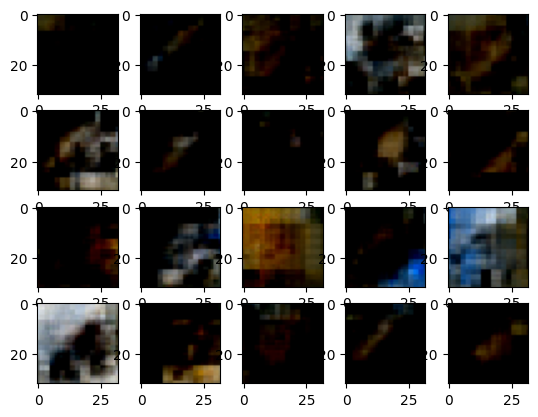

In [11]:
Visualize_Test(Test_dataloader=train_dataloader,model=model)